In [26]:
import mpmath
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_genlaguerre, loggamma
from mpmath import jtheta,sqrt
import csv
from scipy.sparse.linalg import expm
from scipy.linalg import eigvalsh

In [2]:
# calculates the Siegel theta function from Jacobis
def siegel(z1,z2):
    return(np.sqrt(2)*np.exp(-np.pi*z1*z1-np.pi*z2*z2+2j*np.pi*z1*z2)* \
    jtheta(3,np.pi*(1.0j*z1+z2),np.exp(-np.pi))*jtheta(3,np.pi*(z1+1.0j*z2),np.exp(-np.pi)))

# get the phase e^{\xi_q(k)}
def getPhase(kvec,qvec,latticeVec1,latticeVec2):
    k1 = np.dot(kvec,latticeVec1)
    k2 = np.dot(kvec,latticeVec2)
    q1 = np.dot(qvec,latticeVec1)
    q2 = np.dot(qvec,latticeVec2)
    
    qComplex = q1 + 1.0j*q2
    numer = np.exp(-qComplex*np.conj(qComplex)/(8*np.pi))*siegel((k1-qComplex/2)/(2*np.pi),(k2+1.0j*qComplex/2)/(2*np.pi))
    denom= sqrt(siegel(k1/(2*np.pi),k2/(2*np.pi))*siegel((k1-q1)/(2*np.pi),(k2-q2)/(2*np.pi)))
    return(complex(numer/denom))

# get the form factor.  This will lose accuracy around m,n = 150 or so, so let's not go beyond that
def getFormFactor(qvec,m,n,latticeVec1,latticeVec2):
    q1 = np.dot(qvec,latticeVec1)
    q2 = np.dot(qvec,latticeVec2)
    omega = abs(latticeVec1[0]*latticeVec2[1]-latticeVec1[1]*latticeVec2[0])
    z1 = 1.0/np.sqrt(omega)*(latticeVec1[0] + 1.0j*latticeVec1[1])
    z2 = 1.0/np.sqrt(omega)*(latticeVec2[0] + 1.0j*latticeVec2[1])
    gammaQ = np.dot(qvec,latticeVec1)*np.conj(z2) - np.dot(qvec,latticeVec2)*np.conj(z1)
    
    factorialTerm = np.exp(-gammaQ*np.conj(gammaQ)/(8*np.pi))*\
    np.exp(complex(0.5*(loggamma(min(m,n)+1) - loggamma(max(m,n)+1))))
    if n >= m:
        exponentTerm = (1.0j*gammaQ/np.sqrt(4*np.pi))**(n-m)
    else:
        exponentTerm = (1.0j*np.conj(gammaQ)/np.sqrt(4*np.pi))**(m-n)
        
    laguerreTerm = eval_genlaguerre(min(m,n),abs(m-n),gammaQ*np.conj(gammaQ)/(4*np.pi))
    return(factorialTerm*exponentTerm*laguerreTerm)

In [15]:
p = 1
q = 1
phi = (2*np.pi*p)/q
w0 = 0.8/np.sqrt(3) 
w1 = 1.0/np.sqrt(3)
vfkth = 110*np.sqrt(3)

In [16]:
a1 = 2./3*np.array([-np.sqrt(3)/2, -1./2],dtype=complex);
a2 = 2./3*np.array([np.sqrt(3)/2, -1./2],dtype=complex);
b1 = np.array([-np.sqrt(3)/2, -3./2],dtype=complex);
b2 = np.array([np.sqrt(3)/2, -3./2],dtype=complex);

ta1 = 1.0/p*a1
ta2 = q*a2
tb1 = p*b1
tb2 = 1.0/q*b2

s2 = np.array([[0, -1.0j], [1.0j, 0]],dtype=complex)
t1 = np.array([[w0, w1], [w1, w0]],dtype=complex)
t2 = np.array([[w0, w1*np.exp(-2j*np.pi/3)], [w1*np.exp(2j*np.pi/3), w0]],dtype=complex)
t3 = np.array([[w0, w1*np.exp(2j*np.pi/3)], [w1*np.exp(-2j*np.pi/3), w0]],dtype=complex)

In [17]:
omega = ta1[0]*ta2[1] - ta1[1]*ta2[0]
z1 = 1/np.sqrt(omega)*(ta1[0]+1.0j*ta1[1])
z2 = 1/np.sqrt(omega)*(ta2[0]+1.0j*ta2[1])

In [18]:
qvec = 2*np.pi*b1
gQ = np.dot(qvec,ta1)*np.conj(z2)-np.dot(qvec,ta2)*np.conj(z1)
gQbar = np.conj(gQ)

num_landau_calc = 200
num_landau = 100

toExp = np.zeros((num_landau_calc,num_landau_calc),dtype=complex)

for m in range(num_landau_calc-1):
    toExp[m,m+1] = np.sqrt(m+1)*1.0j*gQ/np.sqrt(4*np.pi)
    toExp[m+1,m] = np.sqrt(m+1)*1.0j*gQbar/np.sqrt(4*np.pi)
    
hqp1 = expm(toExp)[:num_landau,:num_landau]

qvec = 2*np.pi*b2
gQ = np.dot(qvec,ta1)*np.conj(z2)-np.dot(qvec,ta2)*np.conj(z1)
gQbar = np.conj(gQ)

toExp2 = np.zeros((num_landau_calc,num_landau_calc),dtype=complex)

for m in range(num_landau_calc-1):
    toExp2[m,m+1] = np.sqrt(m+1)*1.0j*gQ/np.sqrt(4*np.pi)
    toExp2[m+1,m] = np.sqrt(m+1)*1.0j*gQbar/np.sqrt(4*np.pi)
    
hqp2 = expm(toExp2)[:num_landau,:num_landau]

aUp = np.zeros((num_landau, num_landau),dtype='complex') 
aDown = np.zeros((num_landau, num_landau),dtype='complex') 

for m in range(num_landau-1):
    aUp[m+1, m] = np.sqrt(m+1)
    aDown[m,m+1] = np.sqrt(m+1)

iden = np.identity(num_landau,dtype='complex');

spurious = np.zeros((num_landau, num_landau),dtype='complex');
spurious[num_landau-1, num_landau-1] = 10;

kinetic1 = np.sqrt(phi/(2*np.pi))*np.sqrt(3*np.sqrt(3)/(2*np.pi))*np.block([[spurious, aUp], [aDown, spurious]]) - 0.5*np.kron(s2,iden);
kinetic2 = np.sqrt(phi/(2*np.pi))*np.sqrt(3*np.sqrt(3)/(2*np.pi))*np.block([[spurious, aUp], [aDown, spurious]]) + 0.5*np.kron(s2,iden);

In [30]:
def generateHamiltonian(kvec):
    diagKinetic1 = np.zeros((2*num_landau*p,2*num_landau*p),dtype='complex')
    diagKinetic2 = np.zeros((2*num_landau*p,2*num_landau*p),dtype='complex')

    hamiltonian = np.zeros((4*num_landau*p,4*num_landau*p),dtype='complex')
    potential = np.zeros((4*num_landau*p,4*num_landau*p),dtype='complex')
    for v in range(p):
        hamiltonian[v*2*num_landau:(v+1)*2*num_landau,v*2*num_landau:(v+1)*2*num_landau] = kinetic1
        hamiltonian[(v+p)*2*num_landau:(v+1+p)*2*num_landau,(v+p)*2*num_landau:(v+p+1)*2*num_landau] = kinetic2
        
        potential[v*2*num_landau:(v+1)*2*num_landau,(v+p)*2*num_landau:(v+1+p)*2*num_landau] = np.kron(t1,iden)+getPhase(kvec+2*np.pi*b1*v,2*np.pi*b2,ta1,ta2)*np.kron(t3,hqp2) 
        # -1 entry is last entry
        if v == 0:
            potential[(p-1)*2*num_landau:(p)*2*num_landau,(v+p)*2*num_landau:(v+1+p)*2*num_landau] = getPhase(kvec+2*np.pi*b1*v,2*np.pi*b1,ta1,ta2)*np.kron(t2,hqp1)
        else:
            potential[(v-1)*2*num_landau:(v)*2*num_landau,(v+p)*2*num_landau:(v+1+p)*2*num_landau] = getPhase(kvec+2*np.pi*b1*v,2*np.pi*b1,ta1,ta2)*np.kron(t2,hqp1)

    hamiltonian = hamiltonian + potential + potential.conj().T  
    return(vfkth*hamiltonian)

In [31]:
histPoints = []
for i in range(1):
    for r in range(1):
        momentum = 2*np.pi*i/20 * tb1 + 2*np.pi*r/20 * tb2
        eigvals = eigvalsh(generateHamiltonian(momentum))
        histPoints+=list(eigvals)

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-2.46367517e+02, -2.41440167e+02, -2.36512817e+02, -2.31585466e+02,
        -2.26658116e+02, -2.21730765e+02, -2.16803415e+02, -2.11876065e+02,
        -2.06948714e+02, -2.02021364e+02, -1.97094014e+02, -1.92166663e+02,
        -1.87239313e+02, -1.82311963e+02, -1.77384612e+02, -1.72457262e+02,
        -1.67529912e+02, -1.62602561e+02, -1.57675211e+02, -1.52747861e+02,
        -1.47820510e+02, -1.42893160e+02, -1.37965810e+02, -1.33038459e+02,
        -1.28111109e+02, -1.23183759e+02, -1.18256408e+02, -1.13329058e+02,
        -1.0840170

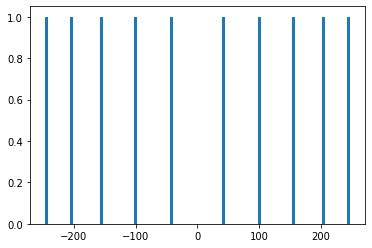

In [32]:
plt.hist([i for i in histPoints if abs(i) < 250],bins=100)

In [113]:
np.save('rawData/data_'+str(p)+'_'+str(q)+'.npy',histPoints)